# Майнор по Анализу Данных, Группа ИАД-2
## 22/03/2017  Деревья решений, случайный лес

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = (10,6)
plt.rc('font', family='Arial')

In [59]:
RANDOM_SEED = 7

# Интро

<center><img src='https://eight2late.files.wordpress.com/2016/02/7214525854_733237dd83_z1.jpg?w=700'><center/>

Формально, дерево решений - это связный ациклический граф. В нем можно выделить 3 типа вершин:
1. Корневая вершина (root node) -  откуда все начинается
2. Внутренние вершины (intermediate nodes)
3. Листья (leafs) - самые глубокие вершины дерева, в которых содержится "ответ"

Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже

#### Обобщенный псевдокод алгоритма построения дерева


```{python}
function decision_tree(X, y):

    if stopping_criterion(X, y) == True:
    
        S = create_leaf_with_prediction(y)
        
    else:
    
        S = create_node()
        (X_1, y_1) .. (X_L, y_L) = best_split(X, y)
        
        for i in 1..L:
            C = decision_tree(X_i, y_i)
            connect_nodes(S, C)
    return S     
```

## Классификация

#### Вопрос: как определяются лучшие разбиения (best splits)?
#### Шаг1: выбираем меру неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$I(S) = 1 - \max\limits_k p_k $$
2. Gini index 
$$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$
3. Entropy 
$$I(S) = -\sum\limits_k p_k \log(p_k)$$


In [3]:
def plot_impurities():
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1-p]  # ?

    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label = 'missclassification error')

    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:,0], gini, label = 'gini index')

    entropy = - np.nansum((p*np.log2(p)), axis=1)
    plt.plot(p[:,0], entropy, label = 'entropy')

    plt.xlabel('$p_k$')
    plt.ylabel('$I(S)$')
    # plt.legend(loc=2, bbox_to_anchor=(0.,0.))
    plt.legend(loc=2, bbox_to_anchor=(-0.3,1))

C:\Users\d_pch\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log2
C:\Users\d_pch\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in multiply


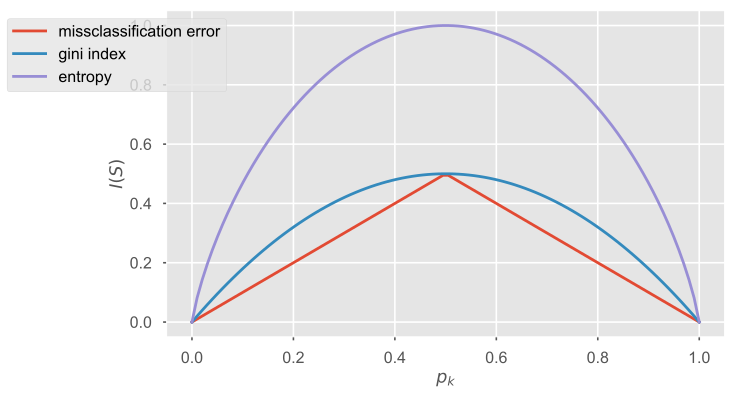

In [5]:
plot_impurities();

#### Шаг 2: Считаем прирост "информации" (определенности)

Выберем признак $A$ и пороговое значение $t$ на нем таким образом, чтобы уменьшить неопределенность:

**Насколько уменьшится неопределенность:** <br/>
$$ Gain(S, A) = I(S) - \left(\frac{|S_L|}{|S|}\cdot I(S_L) + \frac{|S_R|}{|S|}\cdot I(S_R) \right),$$ где $S_R$ и $S_L$ - это потомки узла $S$ c объектами, удовлетворяющим соответствующим условиям.

**Замечания:**
* Стратегия выбора - жадная
* Как определяется порог при вещественных признаках?
* Локальная оптимизация - уменьшение Impurity внутри узла
* Результаты не сильно зависят от выбора самой меры неопределенности


#### Задание
Воспользуемся данными про вино, которые мы видели в ДЗ№0

Имплементируйте понравившаюся вам меру неопределенности и посмотрите, где будет находится оптимальный порог.

In [11]:
def gini_index_impurity_measure(p, axis=0):
    return 1 - (p ** 2).sum(axis=axis)

In [9]:
def impurity_measure(p):
    # Здесь надо внести исправления
    # Выберите меру неопределенности и имплементируйте ее
    # Так как у нас задача классификации на 2 класса, то p - это массив из двух значений
    gini = 1 - (p ** 2).sum(axis=1)
    missclass = 1 - p.max(axis=1)
    entropy = - np.nansum((p*np.log2(p)), axis=1)
    return -np.nansum((p*np.log2(p)))

def wine_demo():
    df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(5)

    # Заменяем целевую переменную на класс (хорошее-плохое вино)
    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')
    
    # 
    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])

    
    init_impurity = impurity_measure(p)
    
    # Зададим значения порогов
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)
    # В этом списке будут хранится величины Gain для каждого порога
    G = []

    for t in t_range:
        idx = df_wine.alcohol < t
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])
        
        #
        G.append(init_impurity - (idx.mean()*impurity_measure(p1) + (1-idx.mean())*impurity_measure(p2)))

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()

C:\Users\d_pch\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log2
C:\Users\d_pch\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in multiply


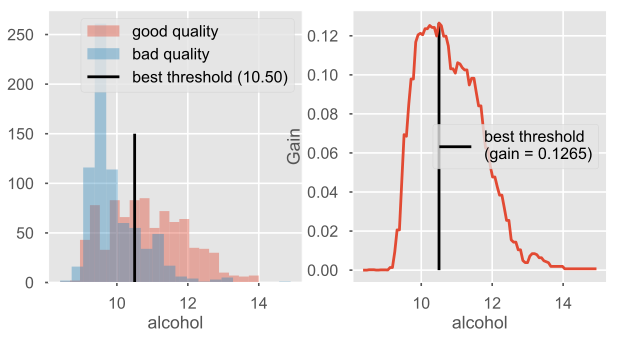

In [10]:
wine_demo()

### Demo

Для того, чтобы демо полностью работало, вам надо установить пакет для визуализации графов [`graphviz`](http://www.graphviz.org/). Если у вас его еще нет, но вы захотите видеть такие картинки - сделайте это, пожалуйста, дома.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess


def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y, s=3)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3)
    ax[1].scatter(X[:,0], X[:,1],c=y, s=3)
    
    try:
        with open('tree.dot', 'w') as fout:
            export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
        command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
        subprocess.check_call(command)
        ax[0].imshow(plt.imread('tree.png'))
        ax[0].axis("off")
    except:
        pass

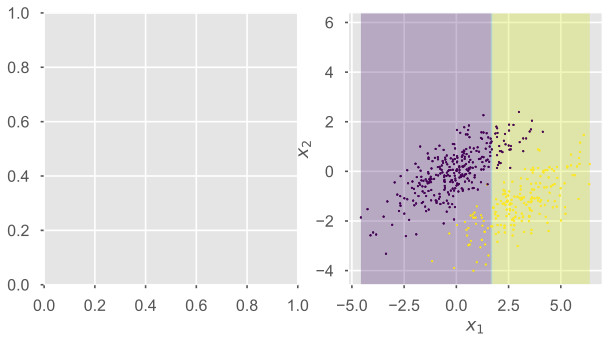

In [38]:
fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=5, value=1))

## Регрессия

Для задачи регрессии в качестве меры неопределенности могут выступать

* Среднее квадратичное отклонение от среднего
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}(y_i - \bar{y_S})^2 $$
* Среднее абсолютное отклонение от медианы
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}|y_i - \bar{y_S}| $$

In [33]:
from sklearn.tree import DecisionTreeRegressor

x_true = np.arange(-5, 5, 0.2)
x = x_true + np.random.rand(x_true.shape[0]) - 0.5
y_true = np.sin(x_true)+x_true/3
y = y_true + np.random.rand(x_true.shape[0]) - 0.5

def plot_dec_reg(depth=1, criterion='mse', ):
    
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)
    
    tree = DecisionTreeRegressor(criterion=criterion, max_depth=depth)
    tree.fit(x.reshape(-1,1), y)
    y_hat = tree.predict(x_true.reshape(-1,1))
    
    ax[1].plot(x_true, y_true, c='g', label='$f(x)$')
    ax[1].scatter(x, y, label='actual data', s=5)
    ax[1].set_xlabel('x_1')
    ax[1].set_ylabel('y')
    ax[1].plot(x_true, y_hat, c='r', label='decision tree \nregression')
    ax[1].legend(loc=2)
    
    try:
        with open('tree.dot', 'w') as fout:
            export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
        command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
        subprocess.check_call(command)
        ax[0].imshow(plt.imread('tree.png'))
        ax[0].axis("off")
    except:
        pass

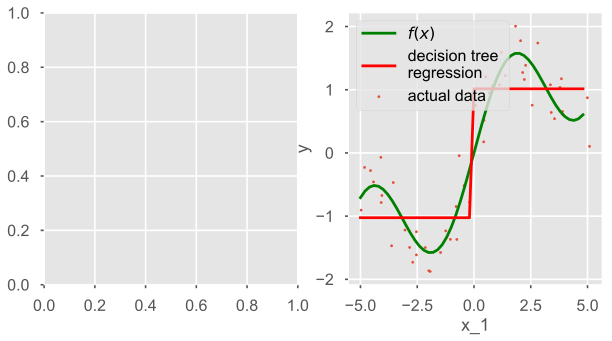

In [34]:
try:
    fig = interact(plot_dec_reg, depth=IntSlider(min=1, max=5, value=1), criterion=['mse', 'mae'])
except:
    print('Что-то не так. Посмотрите на доску')

## Как определяется предсказание?

* Классификация
    * Класс с большинством в листе
    * Доли каждого из классов в листе
* Регрессия
    * Среднее (медиана) целевой переменной в листе

## Преимущества/Недостатки?

Преимущества
* не требуется изменение размеров признаков
* "интерпретируемость"
* отсеиваются незначимые признаки

Недостатки
* переобучение
* не восстанавливают лин. завис

# Практика

Загрузите файл с [данными](https://cloud.mail.ru/public/HoTX/NjK4v8LWx).

Представьте, что вы отвечаете за продвижение детских товаров в одном из магазинов некоторой ритейловой сети. Это значит, что вам нужно сделать так, чтобы подгузники, питательные смеси, соски, игрульки, коляски, манежи и прочией товары, расходились как можно лучше.

Из исследований фокус-группы вы выяснили, что молодые родители привыкают к брендам тех или иных детских товаров довольно быстро. Вам бы хотелось, чтобы потенциальным покупателям понравилось именно в вашем магазине - можно дать им скидку заранее и обеспечить первое место в их списке магазинов. Вот только как определить, что родители ждут ребенка?

Нужна модель!

In [40]:
df_retail = pd.read_csv(r"data/Retail.csv", sep=';')
df_retail.head()

Male  Female  Undefined_Sex  Home  Apt  PO  Pregnancy Test  Birth Control  \
0     0       0              1     0    1   0               0              0   
1     0       0              1     1    0   0               0              0   
2     1       0              0     1    0   0               0              0   
3     1       0              0     1    0   0               0              0   
4     1       0              0     0    1   0               0              0   

   Feminine Hygiene  Folic Acid    ...     Body Pillow  Ginger Ale  Sea Bands  \
0                 0           0    ...               0           0          1   
1                 0           0    ...               0           0          0   
2                 0           0    ...               0           0          0   
3                 0           0    ...               0           0          0   
4                 0           0    ...               0           0          0   

   Stopped buying ciggies  Cigarettes  Smoking Cessation  Stopped buying wine  \
0                       0           0                  0                    1   
1                       0           0                  0                    0   
2                       1           0                  0                    0   
3                       0           0                  0                    1   
4                       0           0                  0                    0   

   Wine  Maternity Clothes  PREGNANT  
0     1                  0         1  
1     0                  0         1  
2     0                  0         1  
3     0                  0         1  
4     0                  0         1  

[5 rows x 22 columns]

#### Задание
* Оцените долю положительного класса в данных
* Разделите данные на обучающую и контрольную выборку случайным образом в пропорции 80/20 (можно c сохранением пропорции классов)
* Вы должны получить матрицы X_train, X_test и  ответы к ним.
* Как бороться с таким дисбалансом в долях классов?

In [69]:
df_retail.PREGNANT.mean()

0.06

In [74]:
y = df_retail.iloc[:, -1].values
X = df_retail.drop('PREGNANT', axis=1)
X.head()

Male  Female  Undefined_Sex  Home  Apt  PO  Pregnancy Test  Birth Control  \
0     0       0              1     0    1   0               0              0   
1     0       0              1     1    0   0               0              0   
2     1       0              0     1    0   0               0              0   
3     1       0              0     1    0   0               0              0   
4     1       0              0     0    1   0               0              0   

   Feminine Hygiene  Folic Acid        ...          Prenatal Yoga  \
0                 0           0        ...                      0   
1                 0           0        ...                      0   
2                 0           0        ...                      0   
3                 0           0        ...                      0   
4                 0           0        ...                      0   

   Body Pillow  Ginger Ale  Sea Bands  Stopped buying ciggies  Cigarettes  \
0            0           0          1                       0           0   
1            0           0          0                       0           0   
2            0           0          0                       1           0   
3            0           0          0                       0           0   
4            0           0          0                       0           0   

   Smoking Cessation  Stopped buying wine  Wine  Maternity Clothes  
0                  0                    1     1                  0  
1                  0                    0     0                  0  
2                  0                    0     0                  0  
3                  0                    1     0                  0  
4                  0                    0     0                  0  

[5 rows x 21 columns]

In [62]:
from sklearn import model_selection
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Сохранение пропорции разбиения.

In [78]:
cv = StratifiedShuffleSplit(y, n_iter=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in cv:
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

TypeError: unhashable type: 'numpy.ndarray'

#### Задание
* Сфокусируемся на гиперпараметре "глубина дерева"
* С помощью кросс-валидации определите наилучшее значение этого параметра
* Попробуйте воспользоваться валидационными кривыми для выбора лучшего значения этого параметра

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

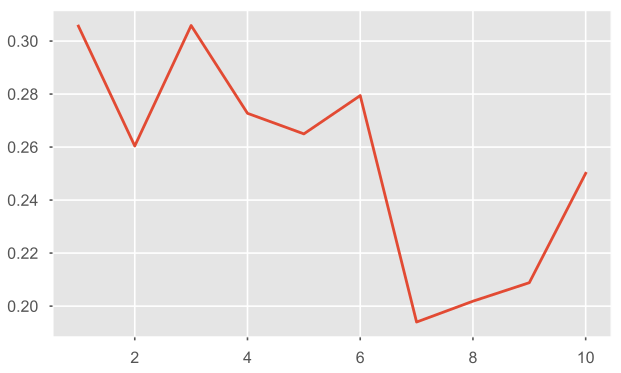

In [109]:
model = DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced')


scores = []

for i in range(10):
    model.set_params(**{'max_depth': i+1})
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean())
    
plt.plot(range(1,11), scores);

In [108]:
validation_curve(model, X_train, y_train, param_name='max_depth', param_range=range(1,11), cv=5, scoring='f1', n_jobs=-1)

(array([[ 0.35416667,  0.43636364,  0.46428571,  0.45283019,  0.46428571],
        [ 0.36956522,  0.17307692,  0.48717949,  0.53164557,  0.51851852],
        [ 0.19537275,  0.5       ,  0.46728972,  0.54545455,  0.5       ],
        [ 0.22981366,  0.6       ,  0.42748092,  0.54368932,  0.5631068 ],
        [ 0.27586207,  0.62337662,  0.48275862,  0.47328244,  0.62365591],
        [ 0.27106227,  0.64864865,  0.51851852,  0.63157895,  0.6744186 ],
        [ 0.27142857,  0.29482072,  0.38043478,  0.67368421,  0.6122449 ],
        [ 0.28252788,  0.42307692,  0.4375    ,  0.64705882,  0.71264368],
        [ 0.30327869,  0.34513274,  0.44303797,  0.68      ,  0.74418605],
        [ 0.57425743,  0.47619048,  0.45962733,  0.77272727,  0.79012346]]),
 array([[ 0.        ,  0.46153846,  0.33333333,  0.4       ,  0.33333333],
        [ 0.        ,  0.13333333,  0.5       ,  0.31578947,  0.35294118],
        [ 0.1627907 ,  0.33333333,  0.42105263,  0.31578947,  0.2962963 ],
        [ 0.19444444,  

#### Важность признаков

В деревьях решений производится автоматический отбор признаков.

Пусть $v(S)$ - это признак, который использовался для ветвления в узле $S$

$$ \text{imp}(A) = \sum\limits_{i: v(S_i) = A} \frac{|S_i|}{|S|} Gain(S_i, A) $$

#### Задание
* Обучите модель на обучающей выборке
* Найдите наиболее важные признаки с помощью `model.feature_importances_`

In [ ]:
# Your Code Here

#### Задание
* Выполните предсказание на контрольной выборке
* Оцените всевозможные меры качества. Сравните с тем, что было на этапе кросс-валидации

In [ ]:
# Your Code Here

# Случайный лес

Bagging - это параллельный способ построения ансамбля.<br/>
1. Обучающая выборка сэмплируется $k$ раз с помощью *bootstrap'a* (выборка с возвратом)
2. На каждом сэмпле обучается отдельная **базовая модель**
3. Ответы моделей усредняются (возможно с весом)
<center><img src='http://image.slidesharecdn.com/ipbimprovingthemodelspredictivepowerwithensembleapproaches-121203224610-phpapp02/95/improving-the-models-predictive-power-with-ensemble-approaches-10-638.jpg?cb=1354575467' width='750'></center>

*Вопрос: Какая доля объектов в среднем попадает в один bootstrap сэмпл?*


Так же есть некоторые обобщения этого подхода:

* Метод случайных подпространств - на шаге 1. сэмплируются не только объекты, но и подпространство признаков
* Метод случайного леса - на каждом узле сэмплируется подпространство признаков

В данном случае, на каждом сэмпле базовой моделью является дерево решений.<br/>
Если вам нужно за минимальное время построить достаточно точную и устойчивую модель - это ваш вариант.

#### Задание
* Проделайте предыдущие этапы для модели случайного леса
* Сравние меры качества
* Почему результаты оказались лучше (должны были)?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Your Code Here

### Comments
* Rotation Forest